In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into 80% train and 20% validation
)

data_dir = '/content/drive/MyDrive/Scanning Electron Microscopy Imaging of Nanoparticles/stutcure'

train_generator = data_gen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # This tells it to use the training split
)

validation_generator = data_gen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # This tells it to use the validation split
)

Found 603 images belonging to 6 classes.
Found 147 images belonging to 6 classes.


In [ ]:
train_generator.i

In [ ]:
model_incep = InceptionV3(weights="imagenet", input_shape=(224, 224, 3), include_top=False)


for layer in model_incep.layers:
    layer.trainable = False

x = Flatten()(model_incep.output)
x = Dense(1024, activation='relu')(x)
x = Dense(6, activation='softmax')(x)  # Softmax for categorical classification

# Final model
model = Model(inputs=model_incep.input, outputs=x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint('best_model.keras', save_best_only=True),
               EarlyStopping(patience=5, restore_best_weights=True),
               ReduceLROnPlateau(patience=3, factor=0.1)]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.3636 - loss: 52.9606 - val_accuracy: 0.4558 - val_loss: 10.8284 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 922ms/step - accuracy: 0.5039 - loss: 9.1542 - val_accuracy: 0.5374 - val_loss: 5.5978 - learning_rate: 0.0010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6493 - loss: 2.6882 - val_accuracy: 0.5510 - val_loss: 4.1452 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 900ms/step - accuracy: 0.6149 - loss: 2.1478 - val_accuracy: 0.4966 - val_loss: 4.0270 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 504ms/step - accuracy: 0.6993 - loss: 1.5534 - val_accuracy: 0.3061 - val_loss: 5.0870 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 527ms/step - accuracy: 0.6917 - loss: 1.6281 - val_accuracy: 0.4830 - val_loss: 4.2288 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 955ms/step - accuracy: 0.7502 - loss: 1.1293 - val_acc

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


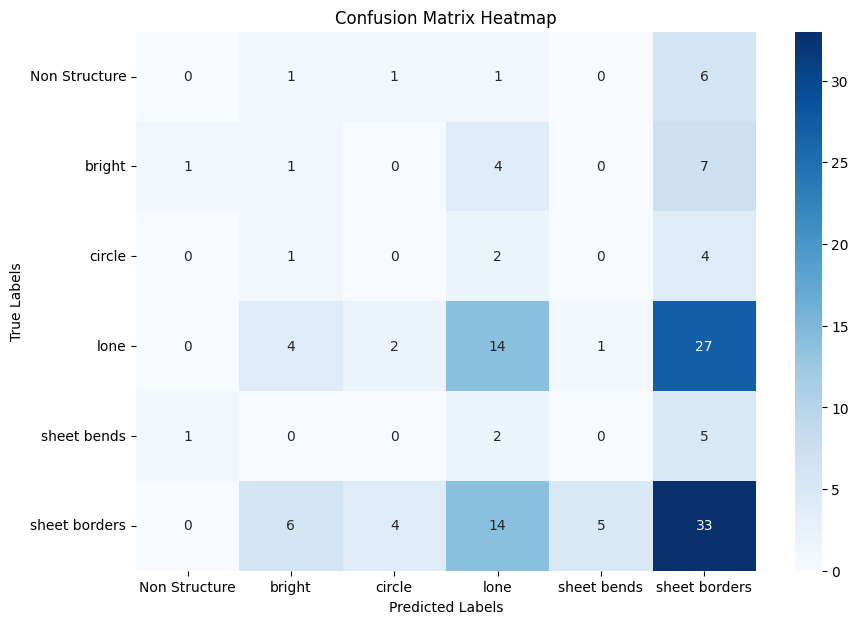

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model
model = load_model('best_model.keras')

# Get true labels and predicted labels
true_labels = validation_generator.classes
predictions = model.predict(validation_generator)

# Convert predictions to class indices
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
